In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import numpy as np
# import tensorflow as tf
import torch.optim as optim
from PIL import Image
from facenet_pytorch import MTCNN
import imageio
from skimage import transform
import torchvision.transforms as Transforms
from utils import pil_loader, NumpyResize, NumpyToTensor
import torchvision.utils as vutils

# from models.utils.image_transform import NumpyResize, pil_loader

# tf.random.set_seed(0)

In [2]:
use_gpu = True if torch.cuda.is_available() else False
latent_dim = 512
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celeba',
                       pretrained=True, useGPU=use_gpu)

Using cache found in /home/vk352/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub
Downloading: "https://dl.fbaipublicfiles.com/gan_zoo/PGAN/celebaCropped_s5_i83000-2b0acc76.pth" to /home/vk352/.cache/torch/hub/checkpoints/celebaCropped_s5_i83000-2b0acc76.pth



Average network found !


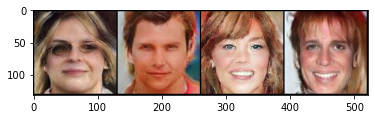

In [6]:
# ignore this
num_images = 4
noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.test(noise)

# let's plot these images using torchvision and matplotlib
grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.savefig('pganExamples.png')

In [109]:
vector = torch.randn(latent_dim).reshape(1, -1)


In [110]:
# vector = noise[-1].reshape(1, -1)

In [111]:
with torch.no_grad():
    generated_images = model.test(vector)

In [112]:
generated_images = generated_images.to(device) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


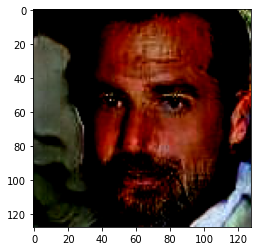

In [113]:
plt.imshow(generated_images.squeeze().permute(1, 2, 0).cpu().numpy())


In [116]:
# img = Image.open('/home/vk352/FaceDetection/datasets/vgg_face2/train/n003682/0009_01.jpg')
img = Image.open('/home/vk352/FaceDetection/datasets/celeba/img_align_celeba/000001.jpg')
mtcnn = MTCNN(image_size=512, margin=200)
generated_images_od = mtcnn(img).unsqueeze(0)
generated_images_od = generated_images_od.to(device) 

In [182]:
image = imageio.imread('/home/vk352/FaceDetection/datasets/celeba/img_align_celeba/000001.jpg')
generated_images_od = torch.tensor(transform.resize(image, [512, 512])).permute(2, 0, 1).unsqueeze(dim=0)
generated_images_od = generated_images_od.to(device) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


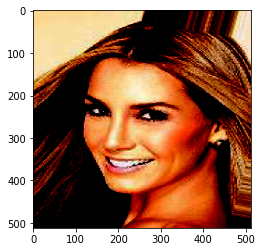

In [172]:
plt.imshow(mtcnn(img).squeeze().permute(1, 2, 0).cpu().numpy())

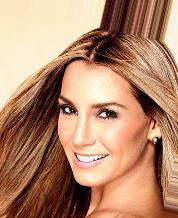

In [176]:
img

In [63]:
v1 = torch.randn(latent_dim)
v2 = torch.randn(latent_dim)

# Creates a tensor with 25 steps of interpolation between v1 and v2.
vectors = interpolate_hypersphere(v1, v2, 50)

In [64]:
with torch.no_grad():
    interpolation = model.test(vectors)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


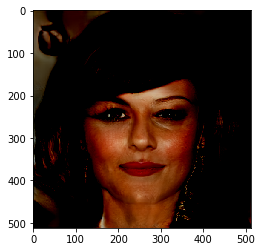

In [78]:
plt.imshow(interpolation[-1].squeeze().permute(1, 2, 0).cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


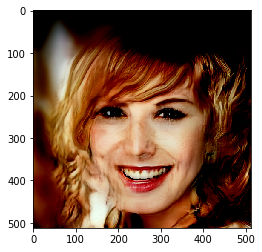

In [54]:
plt.imshow(interpolation[0].squeeze().permute(1, 2, 0).cpu().numpy())

In [114]:
def interpolate_hypersphere(v1, v2, num_steps):
    v1_norm = torch.norm(v1)
    v2_norm = torch.norm(v2)
    v2_normalized = v2 * (v1_norm / v2_norm)

    vectors = []
    for step in range(num_steps):
        interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
        interpolated_norm = torch.norm(interpolated)
        interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
        vectors.append(interpolated_normalized)
    return torch.stack(vectors)

def find_closest_latent_vector(initial_vector, num_optimization_steps,
                               steps_per_image):
    images = []
    losses = []
    
    vector = initial_vector.to(device) 
    vector.requires_grad = True
    optimizer = optim.Adam([vector], lr=0.01)
    # tf equivalent: loss_fn = tf.losses.MeanAbsoluteError(reduction="sum")
    loss_fn = nn.L1Loss(reduction = 'sum')

    for step in range(num_optimization_steps):
        if (step % 100)==0:
              print()
        print('.', end='')
        optimizer.zero_grad()
        ##image = progan(vector.read_value())['default'][0]
        
        image = model.netG(vector)
        
        if (step % steps_per_image) == 0:
            images.append(image)
#         image = image.to(device) 
        target_image_difference = loss_fn(image, generated_images)
      
        # The latent vectors were sampled from a normal distribution. We can get
        # more realistic images if we regularize the length of the latent vector to 
        # the average length of vector from this distribution.
        regularizer = torch.abs(torch.norm(vector) - np.sqrt(latent_dim))

        loss = target_image_difference + regularizer
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step() 
        
    return images, losses


In [115]:
num_optimization_steps=800
steps_per_image=5
initial_vector = torch.randn(latent_dim).reshape(1, -1)
images, loss = find_closest_latent_vector(initial_vector, num_optimization_steps, steps_per_image)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

Text(0.5, 0, 'Step')

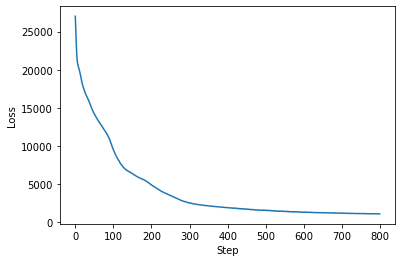

In [46]:
plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('Step')

In [47]:
loss

[27015.326171875,
 25571.1484375,
 24233.0078125,
 22908.8046875,
 21850.9921875,
 21207.662109375,
 20847.79296875,
 20604.275390625,
 20418.34765625,
 20252.15625,
 20077.2734375,
 19881.470703125,
 19679.1328125,
 19448.59765625,
 19219.01171875,
 18944.0625,
 18679.248046875,
 18434.236328125,
 18206.552734375,
 18009.708984375,
 17843.734375,
 17685.056640625,
 17537.125,
 17395.220703125,
 17254.345703125,
 17109.57421875,
 16975.693359375,
 16845.76953125,
 16716.806640625,
 16596.6875,
 16490.458984375,
 16393.58203125,
 16297.4580078125,
 16197.56640625,
 16090.685546875,
 15975.19140625,
 15848.1806640625,
 15718.3115234375,
 15586.6298828125,
 15457.1943359375,
 15330.611328125,
 15202.6689453125,
 15076.0712890625,
 14952.5,
 14830.01171875,
 14712.6318359375,
 14601.3154296875,
 14495.6337890625,
 14392.07421875,
 14293.484375,
 14201.48046875,
 14111.0185546875,
 14018.9345703125,
 13925.9833984375,
 13835.9912109375,
 13747.6669921875,
 13661.2158203125,
 13575.733398437

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


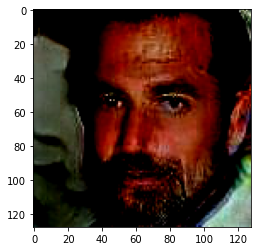

In [116]:
plt.imshow(images[-1].squeeze().permute(1, 2, 0).cpu().detach().numpy())

In [158]:
dir(model)

['ClassificationCriterion',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'addScale',
 'avgG',
 'buildAvG',
 'buildNoiseData',
 'buildNoiseDataWithConstraints',
 'classificationPenalty',
 'config',
 'device',
 'getNetD',
 'getNetG',
 'getOptimizerD',
 'getOptimizerG',
 'getOriginalD',
 'getOriginalG',
 'getSize',
 'getStateDict',
 'initializeClassificationCriterion',
 'load',
 'load_state_dict',
 'lossCriterion',
 'n_devices',
 'netD',
 'netG',
 'optimizeParameters',
 'optimizerD',
 'optimizerG',
 'save',
 'test',
 'trainTmp',
 'updateAlpha',
 'updateConfig',
 'updateSolversDevice',
 'useGPU']

In [77]:
size=(128,128)
cx = 89
cy = 121

In [78]:
transformList = [NumpyResize(size),
                         NumpyToTensor(),
                         Transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
transformList

[NumpyResize,
 Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]

In [79]:
transform = Transforms.Compose(transformList)

In [80]:
transform

Compose(
    NumpyResize
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [87]:
pt = '/home/vk352/FaceDetection/datasets/celeba/img_align_celeba/128744.jpg'
img = np.array(pil_loader(pt))
img = img[cy - 64: cy + 64, cx - 64: cx + 64]

In [88]:
transform(img)

hi
resize done


tensor([[[ 0.6392,  0.6392,  0.6392,  ...,  0.5529,  0.5529,  0.5686],
         [ 0.6392,  0.6392,  0.6392,  ...,  0.5529,  0.5529,  0.5686],
         [ 0.6392,  0.6392,  0.6392,  ...,  0.5608,  0.5608,  0.5686],
         ...,
         [ 0.7725,  0.7490,  0.5451,  ...,  0.5922,  0.5922,  0.5922],
         [ 0.6627,  0.3098, -0.0745,  ...,  0.5922,  0.5922,  0.5922],
         [ 0.2078, -0.1059, -0.1529,  ...,  0.6078,  0.5922,  0.5765]],

        [[ 0.4745,  0.4745,  0.4745,  ...,  0.4039,  0.4039,  0.4196],
         [ 0.4745,  0.4745,  0.4745,  ...,  0.4039,  0.4039,  0.4196],
         [ 0.4745,  0.4745,  0.4745,  ...,  0.4118,  0.4118,  0.4196],
         ...,
         [ 0.4431,  0.4118,  0.1686,  ...,  0.3804,  0.3804,  0.3804],
         [ 0.3255, -0.0667, -0.4824,  ...,  0.3804,  0.3804,  0.3804],
         [-0.1686, -0.5137, -0.5686,  ...,  0.3961,  0.3804,  0.3647]],

        [[ 0.3412,  0.3412,  0.3412,  ...,  0.2863,  0.2863,  0.3020],
         [ 0.3412,  0.3412,  0.3412,  ...,  0

In [89]:
generated_images_od = transform(img).unsqueeze(dim=0)
generated_images_od = generated_images_od.to(device) 

hi
resize done


In [90]:
generated_images_od.shape

torch.Size([1, 3, 128, 128])

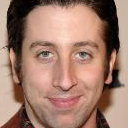

In [91]:
Image.fromarray(img)

Using cache found in /home/vk352/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


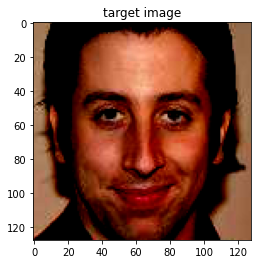

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


.23709.421875


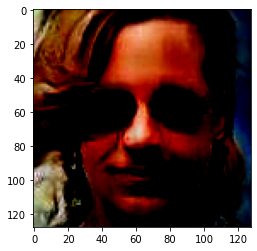

....................................................................................................8601.93359375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


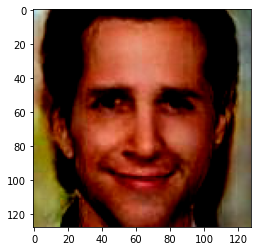

...........................................................................................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


.........7213.1640625


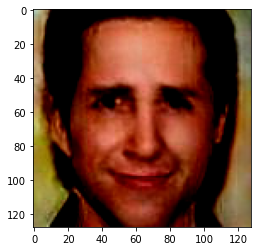

....................................................................................................6437.62109375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


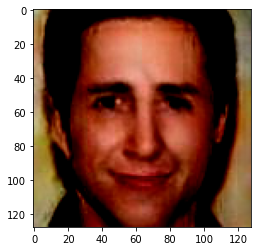

...........................................................................................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


.........5853.6787109375


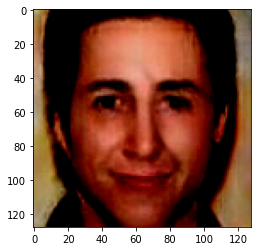

...........................................................................................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


.........5445.6796875


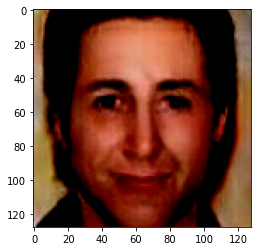

...........................................................................................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


.........5252.0400390625


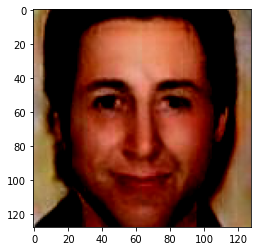

...........................................................................................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


.........5103.802734375


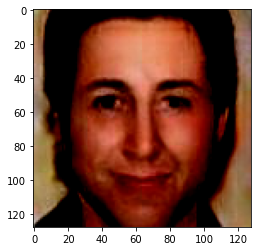

...........................................................................................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


.........4999.64697265625


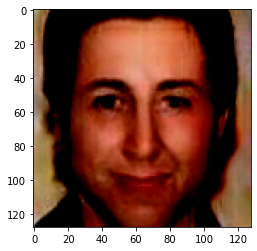

...........................................................................................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


.........4940.634765625


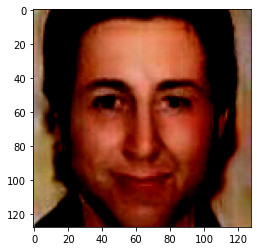

...................................................................................................

In [93]:
use_gpu = True if torch.cuda.is_available() else False
latent_dim = 512
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celeba',
                       pretrained=True, useGPU=use_gpu)
seed = 1
torch.manual_seed(seed)
plt.figure(0)
plt.imshow(generated_images_od.clamp(min=-1, max=1).squeeze().permute(1, 2, 0).cpu().numpy())
plt.title("target image")
plt.show()
def find_closest_latent_vector(initial_vector, num_optimization_steps,
                               steps_per_image, lr=0.01):
    images = []
    losses = []
    
    vector = initial_vector.to(device) 
    vector.requires_grad = True
    optimizer = optim.Adam([vector], lr=lr)
    # tf equivalent: loss_fn = tf.losses.MeanAbsoluteError(reduction="sum")
    loss_fn = nn.L1Loss(reduction = 'sum')
    for step in range(num_optimization_steps):
        print('.', end='')
        optimizer.zero_grad()
        ##image = progan(vector.read_value())['default'][0]
        #image = model.test(vector)
        image = model.netG(vector)
        if (step % steps_per_image) == 0:
            images.append(image.detach().cpu().numpy())
        image = image.to(device) 
        target_image_difference = loss_fn(image, generated_images_od)
      
        # The latent vectors were sampled from a normal distribution. We can get
        # more realistic images if we regularize the length of the latent vector to 
        # the average length of vector from this distribution.
        regularizer = torch.abs(torch.norm(vector) - np.sqrt(latent_dim))
        loss = target_image_difference + regularizer
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step() 
        if (step % 100)==0:
            print(loss.item())
            plt.figure(step)
            plt.imshow(image.squeeze().clamp(min=-1, max=1).permute(1, 2, 0).detach().cpu().numpy())
            plt.show()
    return images, losses
num_optimization_steps=1000
steps_per_image=5
initial_vector = torch.randn(latent_dim).reshape(1, -1)
images, loss = find_closest_latent_vector(initial_vector, num_optimization_steps, steps_per_image, lr=1e-2)

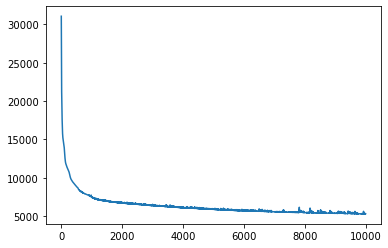

In [131]:
plt.plot(loss)

In [33]:
# vutils.save_image(torch.tensor(images[-1]), "fin.png")